### 用死傷人數做 OLS 模型

In [2]:
import pandas as pd
import numpy as np

# 讀取 A1 與 A2 資料
high = pd.read_csv("high_popularity_spotify_data.csv")
low = pd.read_csv("low_popularity_spotify_data.csv")


df = pd.concat([high, low], ignore_index=True)
df.head()

#df['playlist_genre'].value_counts()


,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [3]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)

# 合併 rare genres 為 "其他"
threshold = 50  # 少於 50 則視為 rare
vc = df['playlist_genre'].value_counts()
rare = vc[vc < threshold].index
df['playlist_genre_clean'] = df['playlist_genre'].replace(rare, '其他')

genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors], genre_dummies], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     45.90
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        14:01:23   Log-Likelihood:                -20398.
No. Observations:                4830   AIC:                         4.089e+04
Df Residuals:                    4783   BIC:                         4.120e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

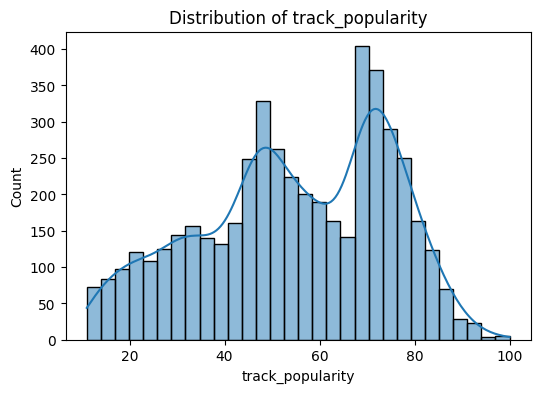

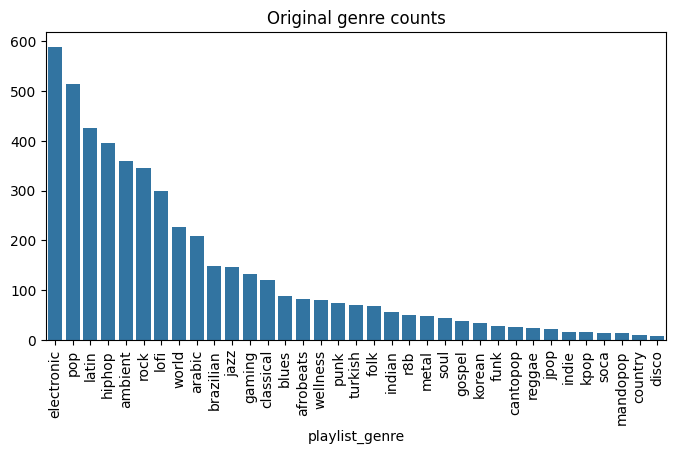

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


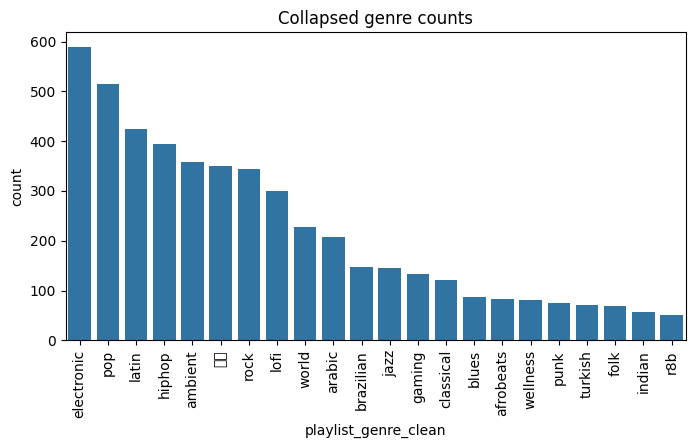

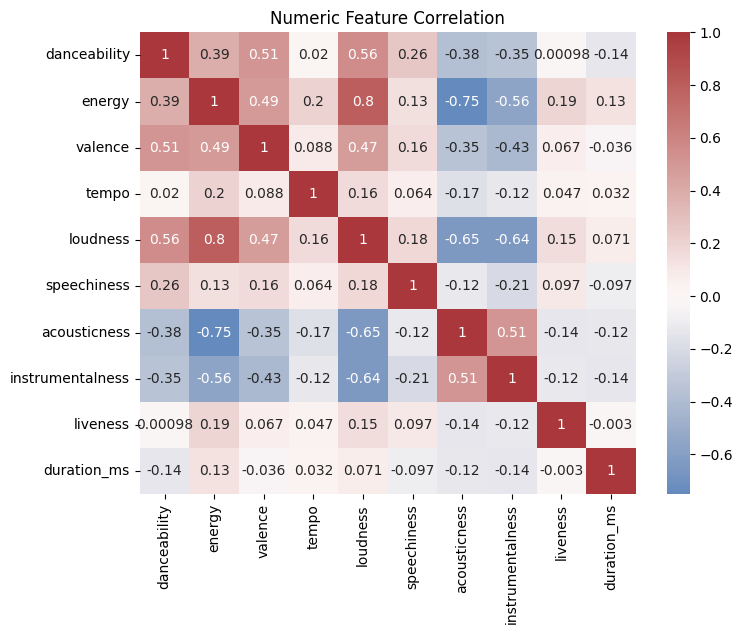

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2. 敘述性統計 & 視覺化
# 2.1 目標分布
plt.figure(figsize=(6,4))
sns.histplot(df['track_popularity'], bins=30, kde=True)
plt.title("Distribution of track_popularity")
plt.show()

# 2.2 clean genre 次數
plt.figure(figsize=(8,4))
sns.barplot(x=vc.index, y=vc.values)
plt.xticks(rotation=90)
plt.title("Original genre counts")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='playlist_genre_clean',
              order=df['playlist_genre_clean'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Collapsed genre counts")
plt.show()

# 2.3 數值變數相關係數熱圖
num_cols = ['danceability','energy','valence','tempo','loudness',
            'speechiness','acousticness','instrumentalness','liveness','duration_ms']
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Numeric Feature Correlation")
plt.show()

In [ ]:
from itertools import combinations

def backward_selection(data, response, threshold_in=0.05):
    initial_features = []
    remaining_features = list(data.columns)
    remaining_features.remove(response)

    while True:
        changed = False
        worst_pval = 0
        worst_candidate = None

        for candidate in remaining_features:
            formula = "{} ~ {}".format(response, ' + '.join(remaining_features))
            model = smf.ols(formula, data).fit()
            pval = model.pvalues[candidate]
            if pval > threshold_in and pval > worst_pval:
                worst_candidate = candidate
                worst_pval = pval

        if worst_candidate is not None:
            remaining_features.remove(worst_candidate)
            changed = True
            print(f"{worst_candidate} is removed with p-value {worst_pval:.4f}.")
            print()

        if not changed:
            print('No variable is removed. Stop.')
            break

    formula = "{} ~ {}".format(response, ' + '.join(remaining_features))
    model = smf.ols(formula, data).fit()
    return model



## Backward Stepwise Regression
### 應變數為 track_popularity


In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

liveness is removed with p-value 0.9714.

genre_soul is removed with p-value 0.8937.

genre_mandopop is removed with p-value 0.7334.

genre_lofi is removed with p-value 0.7634.

genre_ambient is removed with p-value 0.6624.

duration_ms is removed with p-value 0.6585.

mode is removed with p-value 0.5505.

acousticness is removed with p-value 0.4246.

genre_latin is removed with p-value 0.3427.

genre_reggae is removed with p-value 0.3427.

genre_country is removed with p-value 0.2861.

tempo is removed with p-value 0.2366.

energy is removed with p-value 0.1674.

genre_jazz is removed with p-value 0.1677.

genre_electronic is removed with p-value 0.0753.

genre_indie is removed with p-value 0.0577.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                

### 🔍 殘差圖觀察重點
#### ✅ 水平橘線是殘差平均線（0）
正常情況下，點應大致分布在橘線上下，無明顯形狀。

#### ❌ 圖中問題
漏斗形（右側較窄）：

表示 異質變異（heteroscedasticity），預測值越大時殘差變異越小，這違反了迴歸分析的基本假設（殘差變異應該一致）。

意味著模型對於不同預測值的解釋力不一致，可能在中低預測值時失準。

非隨機分布：

正常的殘差圖應呈現無規律的雲狀分布，但這張圖呈現某種錐形，可能代表模型形式錯誤（例如少了非線性項）。

Text(0, 0.5, 'Standardized Residuals of track popularity')

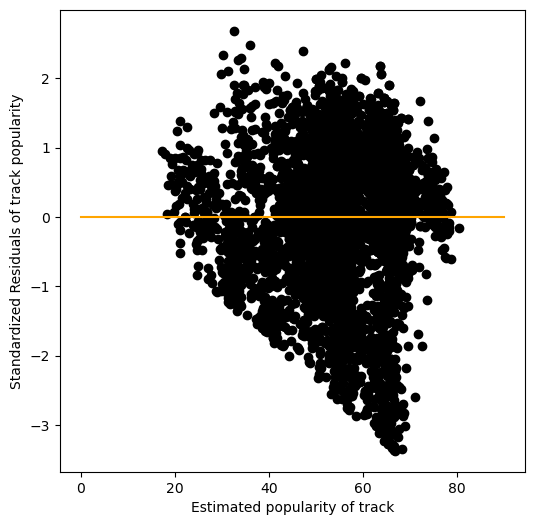

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

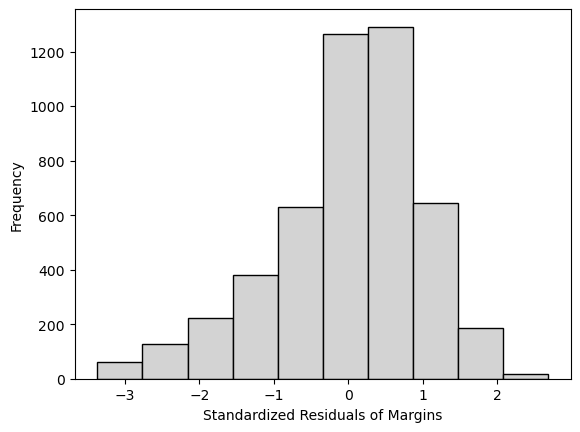

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.1478568147752e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## 三個交互作用項
這裡我們建立了三個交互作用項：

- `danceability_tempo`：舞蹈性 × 節奏（danceability × tempo），反映歌曲的舞蹈感與節奏快慢的綜合效果。
- `danceability_energy`：舞蹈性 × 能量（danceability × energy），結合舞蹈感與能量感，捕捉兩者同時高或低時的影響。
- `energy_valence`：能量 × 愉悅度（energy × valence），用來觀察高能量且愉悅的歌曲是否特別受歡迎。

這些交互作用項有助於模型捕捉變數間非線性的聯合效果，提升預測能力。

In [ ]:
# 先建立交互作用項
data_interact = data.copy()
# 1. danceability × tempo
data_interact['danceability_tempo'] = data_interact['danceability'] * data_interact['tempo']
# 2. danceability × energy
data_interact['danceability_energy'] = data_interact['danceability'] * data_interact['energy']
# 3. energy × valence
data_interact['energy_valence'] = data_interact['energy'] * data_interact['valence']

# 準備 response
response = 'track_popularity'

# 將所有 predictor（原本的 + 交互作用項）組合
predictors_interact = [col for col in data_interact.columns if col != response]

# 執行 backward selection
result_interact = backward_selection(data_interact[predictors_interact + [response]], response=response)
print(result_interact.summary())

liveness is removed with p-value 0.9624.

genre_soul is removed with p-value 0.8417.

genre_mandopop is removed with p-value 0.7422.

genre_ambient is removed with p-value 0.7773.

genre_lofi is removed with p-value 0.6791.

duration_ms is removed with p-value 0.6026.

mode is removed with p-value 0.4990.

genre_latin is removed with p-value 0.4078.

genre_reggae is removed with p-value 0.3707.

genre_country is removed with p-value 0.3557.

danceability_tempo is removed with p-value 0.3267.

acousticness is removed with p-value 0.2532.

energy_valence is removed with p-value 0.2474.

genre_jazz is removed with p-value 0.1813.

tempo is removed with p-value 0.1311.

genre_arabic is removed with p-value 0.0586.

genre_turkish is removed with p-value 0.0854.

genre_gospel is removed with p-value 0.0682.

valence is removed with p-value 0.0683.

danceability is removed with p-value 0.0540.

No variable is removed. Stop.
                            OLS Regression Results                   

Text(0, 0.5, 'Standardized Residuals of track popularity')

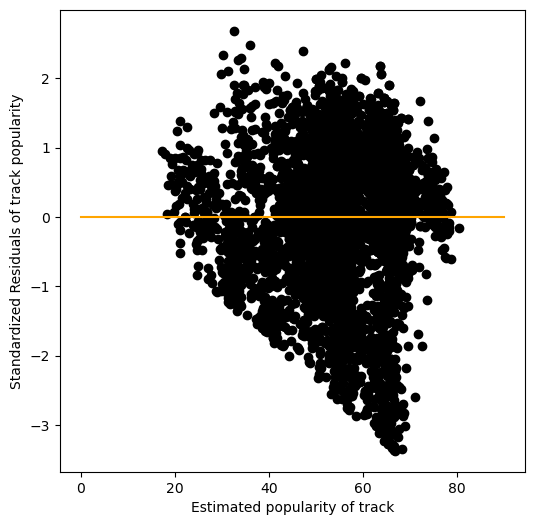

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

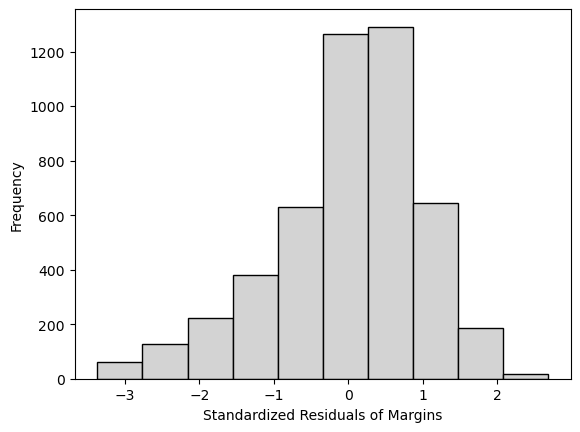

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.1478568147752e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## Backwards Stepwise Regression
### 應變數為 $ \log(\text{track\_popularity}) $

In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy

# 將 track_popularity 取 log（加 1 防止 log(0)）
df['track_popularity'] = np.log(df['track_popularity'])
predictors = [col for col in df.columns if col not in exclude_cols]


data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

genre_turkish is removed with p-value 0.9867.

genre_arabic is removed with p-value 0.9603.

liveness is removed with p-value 0.9158.

genre_gospel is removed with p-value 0.8633.

genre_country is removed with p-value 0.7872.

genre_latin is removed with p-value 0.6493.

mode is removed with p-value 0.3659.

genre_jazz is removed with p-value 0.3472.

tempo is removed with p-value 0.2499.

genre_mandopop is removed with p-value 0.2417.

duration_ms is removed with p-value 0.2172.

valence is removed with p-value 0.2273.

genre_soul is removed with p-value 0.2176.

genre_reggae is removed with p-value 0.1490.

acousticness is removed with p-value 0.1035.

energy is removed with p-value 0.1085.

genre_ambient is removed with p-value 0.0940.

speechiness is removed with p-value 0.0787.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.259
Model:          

Text(0, 0.5, 'Residuals of log(track popularity)')

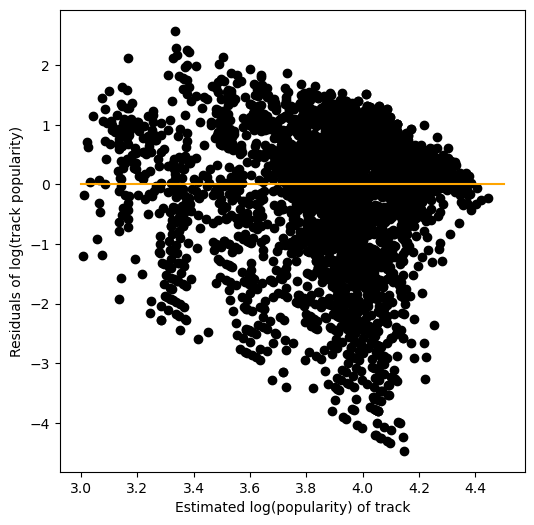

In [ ]:
influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([3, 4.5], [0, 0], color = 'orange')
plt.xlabel('Estimated log(popularity) of track')
plt.ylabel('Residuals of log(track popularity)')


Text(0, 0.5, 'Frequency')

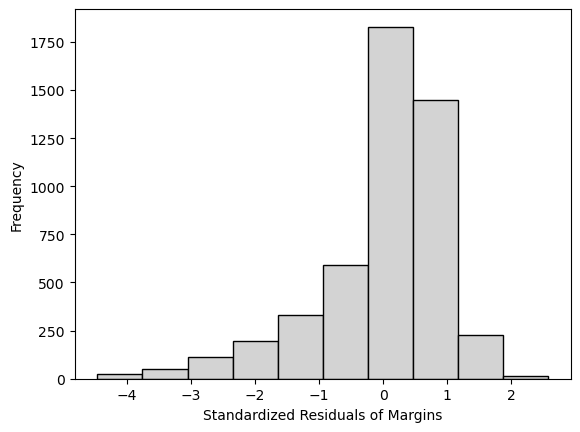

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

2.668231180958147e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.8934
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -39.0126
p-value: 0.0000


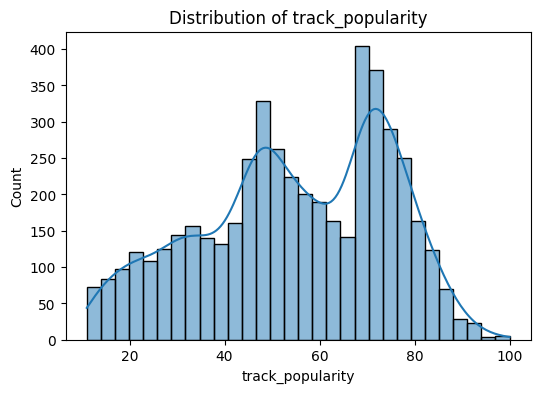

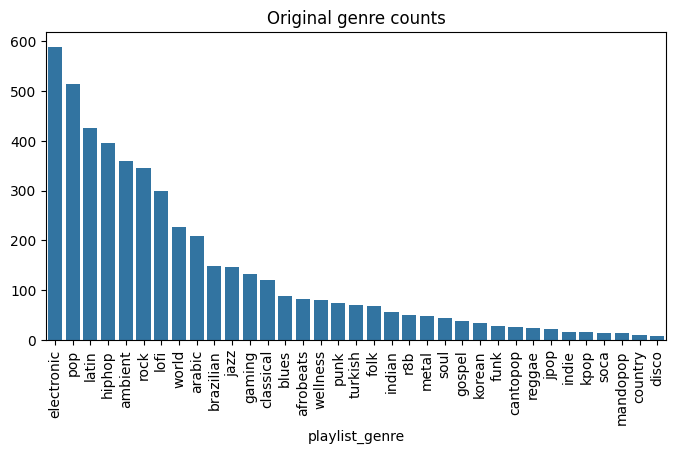

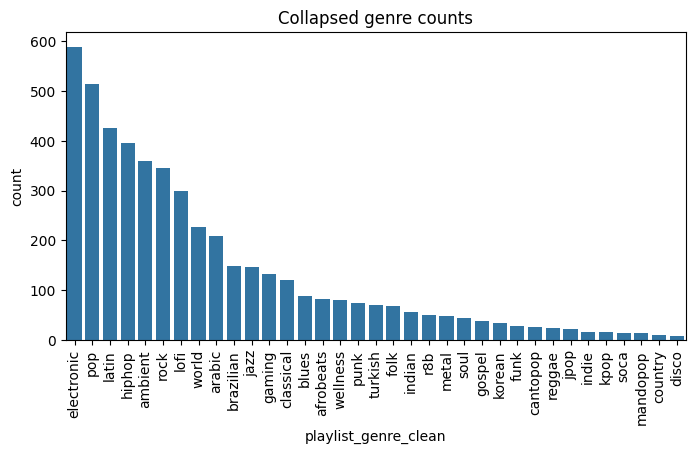

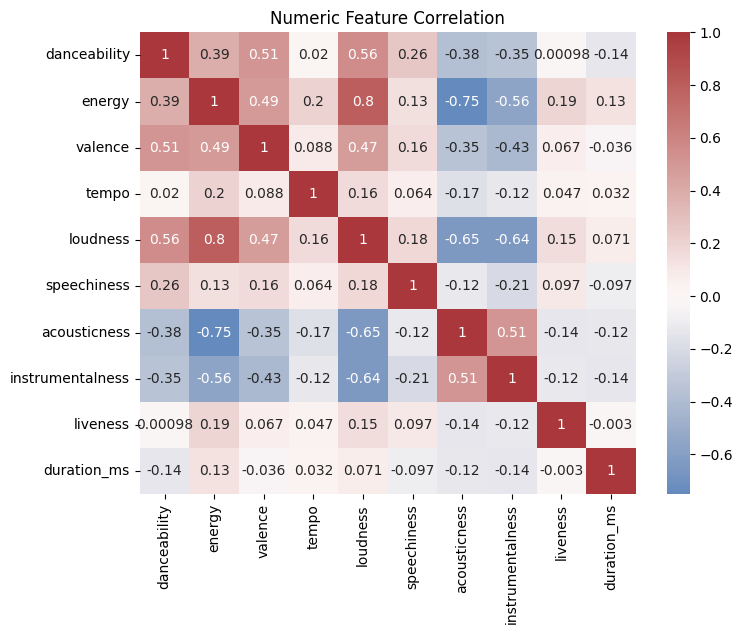

            variable         VIF
0              const  213.729823
1             energy    4.894393
2              tempo    1.070083
3       danceability    2.367063
4           loudness    5.696733
5           liveness    1.084093
6            valence    1.858022
7        speechiness    1.390445
8   instrumentalness    3.066670
9               mode    1.092595
10               key    1.030645
11       duration_ms    1.376245
12      acousticness    2.720312
13     genre_ambient    5.262329
14      genre_arabic    3.495866
15       genre_blues    2.095812
16   genre_brazilian    2.785959
17    genre_cantopop    1.356030
18   genre_classical    2.761068
19     genre_country    1.150349
20       genre_disco    1.123319
21  genre_electronic    7.487364
22        genre_folk    1.904215
23        genre_funk    1.369129
24      genre_gaming    2.638969
25      genre_gospel    1.567161
26      genre_hiphop    5.582685
27      genre_indian    1.698730
28       genre_indie    1.213319
29        

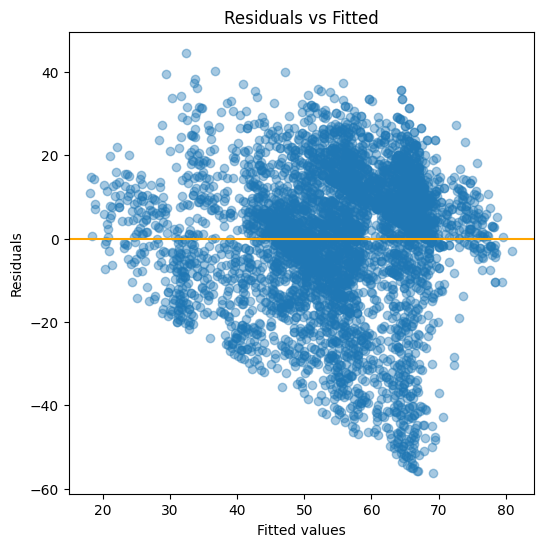

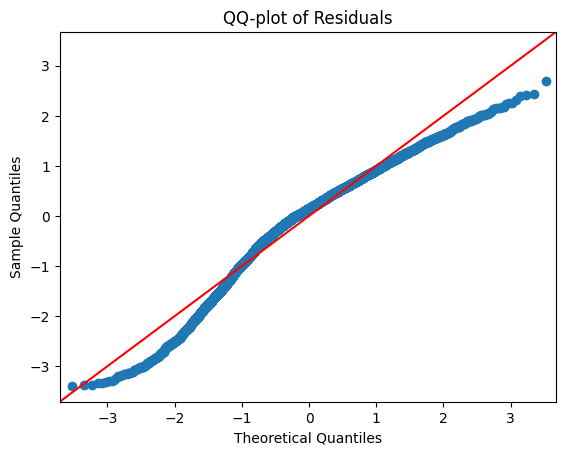

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 讀資料
high = pd.read_csv("high_popularity_spotify_data.csv")
low  = pd.read_csv("low_popularity_spotify_data.csv")
df   = pd.concat([high, low], ignore_index=True)

df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

# 1. 合併 rare genres 為 "其他"
threshold = 0  # 少於 50 則視為 rare
vc = df['playlist_genre'].value_counts()
rare = vc[vc < threshold].index
df['playlist_genre_clean'] = df['playlist_genre'].replace(rare, 'other')
# df.columns = df.columns.str.replace('r&b', 'r8b')


# 2. 敘述性統計 & 視覺化
# 2.1 目標分布
plt.figure(figsize=(6,4))
sns.histplot(df['track_popularity'], bins=30, kde=True)
plt.title("Distribution of track_popularity")
plt.show()

# 2.2 clean genre 次數
plt.figure(figsize=(8,4))
sns.barplot(x=vc.index, y=vc.values)
plt.xticks(rotation=90)
plt.title("Original genre counts")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='playlist_genre_clean',
              order=df['playlist_genre_clean'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Collapsed genre counts")
plt.show()

# 2.3 數值變數相關係數熱圖
num_cols = ['danceability','energy','valence','tempo','loudness',
            'speechiness','acousticness','instrumentalness','liveness','duration_ms']
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Numeric Feature Correlation")
plt.show()

# 3. Dummy encoding
genre_dummies = pd.get_dummies(df['playlist_genre_clean'],
                               prefix='genre', drop_first=True).astype(int)

# 4. 建立 modeling dataframe
#    除去不必要的 raw 欄位
drop_cols = ['track_artist','time_signature','track_href','uri','track_album_name',
             'playlist_name','analysis_url','track_id','track_name',
             'track_album_release_date','track_album_id','id',
             'playlist_subgenre','type','playlist_id','playlist_genre']
df2 = df.drop(columns=drop_cols + ['playlist_genre'])

# 合併 dummy
df_model = pd.concat([df2, genre_dummies], axis=1)

# 5. 共線性檢查：算 VIF 並列出前 10 高
'''
X = df_model.drop(columns=['track_popularity'])
X = sm.add_constant(X)
vif = pd.DataFrame({
    'variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})
vif = vif.sort_values('VIF', ascending=False).head(10)
print("Top 10 VIF:")
print(vif)
'''

# 假设 X_raw 是你原始的自变量 DataFrame
# 只保留数值型
X = df_model.drop(columns=['track_popularity'])
X = sm.add_constant(X) # 截距項
X_num = X.select_dtypes(include=[np.number]).copy()

# 如果还有 NaN/inf，要先丢掉或填补
X_num = X_num.replace([np.inf, -np.inf], np.nan).dropna()

# 然后再算 VIF
vif = pd.DataFrame({
    'variable': X_num.columns,
    'VIF': [variance_inflation_factor(X_num.values, i)
            for i in range(X_num.shape[1])]
})
print(vif)

# （視需要自行 drop VIF 過高的欄位）

# 6. OLS + backward stepwise（示意）
response = 'track_popularity'
predictors = [c for c in df_model.columns if c != response]
formula = response + " ~ " + " + ".join(predictors)
model = smf.ols(formula, data=df_model).fit()

print(model.summary())

# 7. 殘差圖檢查
resid = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(6,6))
plt.scatter(fitted, resid, alpha=0.4)
plt.axhline(0, color='orange')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# 8. QQ-plot for normality
sm.qqplot(resid, line='45', fit=True)
plt.title("QQ-plot of Residuals")
plt.show()


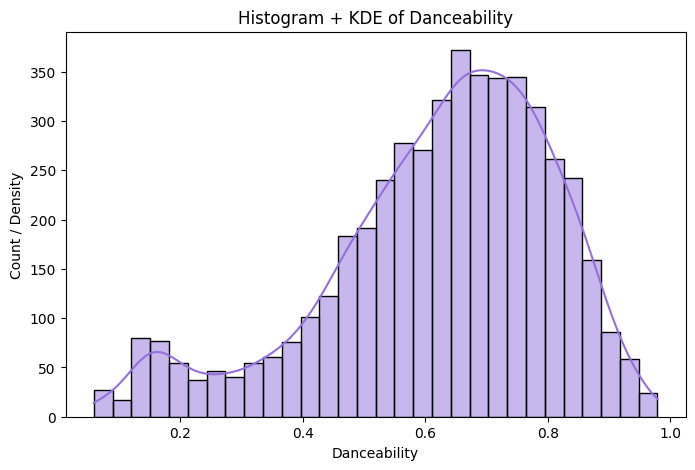

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(df['danceability'], bins=30, kde=True, color='mediumpurple')
plt.title("Histogram + KDE of Danceability")
plt.xlabel("Danceability")
plt.ylabel("Count / Density")
plt.show()


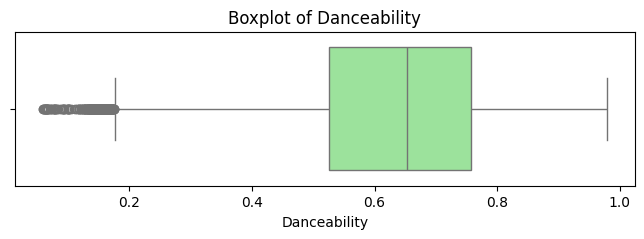

In [15]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['danceability'], color='lightgreen')
plt.title("Boxplot of Danceability")
plt.xlabel("Danceability")
plt.show()
